In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
# import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.ext.declarative import declarative_base

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
''' 
Reflecting tables into SQLAlchemy ORM is equivalent to creating classes that correspond to the tables in the database.
So we can use these classes to access the database using Python code instead of writing SQL queries.
The automap_base() function in SQLAlchemy can be used to reflect tables into classes. 
Once the tables are reflected, we can use variables for each table to access them with python. 

The prepare function is used to reflect an existing database into a new model1. 
It creates a new AutomapBase class in a similar manner as to how the declarative base class is created, using automap_base().
We then call AutomapBase.prepare() on the resulting base class, asking it to reflect the schema and produce mappings.

'''
b = automap_base()
b.prepare(engine, reflect=True)
# reflect the tables
# s = b.classes.station
# s
reflect = b.classes.measurement
type(reflect)

sqlalchemy.orm.decl_api.DeclarativeMeta

In [7]:
# View all of the classes that automap found
index = 0
for elem in b.classes:
    index += 1
    print("Class number", str(index), elem.__name__)
    # print([x.__name__ for x in b.classes])


Class number 1 measurement
Class number 2 station


In [8]:
# Save references to each table
measurement = b.classes.measurement
station = b.classes.station
# measurement
# station

In [9]:
'''  Create our session (link) from Python to the DB  '''
session = Session(engine)
# Base = declarative_base()

# Exploratory Precipitation Analysis

In [476]:
'''Find the most recent date in the data set. '''
# Referenced https://stackoverflow.com/questions/35060041/sqlalchemy-formatting-a-db-datetime-column-result

''' 1. Find the most recent date in the dataset.'''
most_recent_date = session.query(func.max(measurement.date)).scalar() # most recent date
#oldest_date = session.query(func.min(measurement.date)).scalar() # oldest date
most_recent_date = session.query(func.max(measurement.date)).one()[0] 
#Another method is to ge the first element or the list 
print("The most recent date is", "'"+most_recent_date+"'", "out of", len([x for x in (session.query(measurement.date))]), \
    "dates, the oldest date is", "'"+(session.query(func.min(measurement.date)).scalar())+"'" ) 
# most_recent_date

The most recent date is '2017-08-23' out of 19550 dates, the oldest date is '2010-01-01'


'2017-08-23'

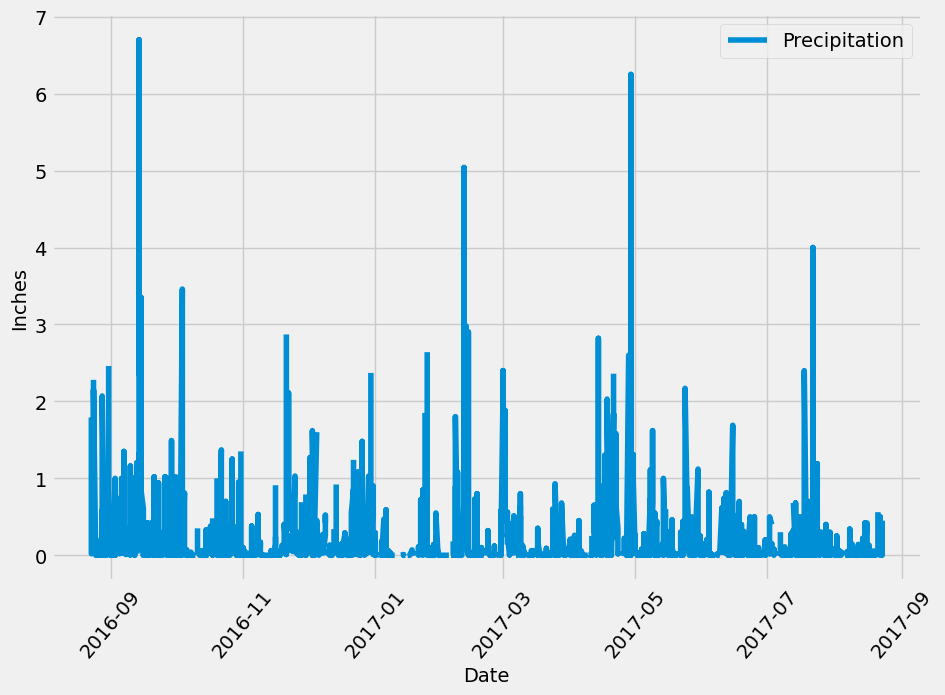

In [478]:
''' 2. Using that date, get the previous 12 months of precipitation data by querying the previous 12 months of data''' 
'''3. Select Only the "date" and "prcp values'''
mrd_dt_object = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()
prev_twelve_mo = (mrd_dt_object) - (dt.timedelta(days=365))
last_twelve_months = session.query(measurement.date, measurement.prcp).filter(measurement.date >= prev_twelve_mo)    
#.filter(measurement.date > (dt.datetime.now() - timedelta(days=365))).all()
#session.query(measurement.date, measurement.prcp).filter(measurement.date >= '2016-08-23').order_by(measurement.date).all()

''' 4.Load the query results into a Pandas DataFrame. Explicitly set the column names.'''
last_twelve_months_df = pd.DataFrame(last_twelve_months)
last_twelve_months_df.rename(columns={'date': 'Date', 'prcp': 'Precipitation'}, inplace=True)

# date_precip_score = pd.read_sql("SELECT date, prcp FROM measurement", engine)
# alldata_measurement =  pd.read_sql("SELECT * FROM measurement", engine)
# alldata_stations =  pd.read_sql("SELECT * FROM station", engine)
# alldata_measurement
# alldata_stations

''' 5. Sort the DataFrame values by "date".'''
# last_twelve_months_df = date_precip_score.sort_values(by='date')
last_twelve_months_df['Date'] = pd.to_datetime(last_twelve_months_df['Date'])
last_twelve_months_df = last_twelve_months_df.sort_values(by=['Date'])
# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_twelve_months_df.to_csv('./Resources/date_precipitation_from_measurement.csv', index=False)

# # Use Pandas Plotting with Matplotlib to plot the data
# precipitation_data = pd.read_sql("SELECT date, prcp FROM measurement WHERE date BETWEEN '2016-08-23' AND '2017-08-23'",engine)
''' 6. Plot the results by using the DataFrame plot method, as the following image shows:'''
lab = ["Precipitation"]
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.plot(last_twelve_months_df['Date'], last_twelve_months_df['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Inches')

# plt.title('Precipitation Data', x=0.1, y=0.9)
plt.legend(lab,loc="upper right")
plt.xticks(rotation = 50)
plt.show()


In [525]:
''' 7. Use Pandas to print the summary statistics for the precipitation data.'''
alldata_measurement =  pd.read_sql("SELECT * FROM measurement", engine)
summary_statistics = alldata_measurement['prcp'].describe()
summary_stats_l12mo = last_twelve_months_df['Precipitation'].describe()
print("SUMMARY STATISTICS FOR THE LAST 12 MONTHS OF PRECIPITATION DATA")
print(summary_stats_l12mo)
print()
print("-------------------------------------------------------------------------")
print()
print("SUMMARY STATISTICS FOR ENTIRE PRECIPITATION DATA")
summary_statistics

SUMMARY STATISTICS FOR THE LAST 12 MONTHS OF PRECIPITATION DATA
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

-------------------------------------------------------------------------

SUMMARY STATISTICS FOR ENTIRE PRECIPITATION DATA


count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [614]:
''' 1. Design a query to calculate the total number of stations in the dataset'''
total_num_stations = len(session.query(station.station).group_by(station.station).all())
# total_num_stations
print(f'Total number of statons is {total_num_stations}. Here are their IDs: ')
listOfStations = str([x for x in session.query(station.station).group_by(station.station).all()]) \
 .replace("(", "").replace(",)", "").replace("[", "").replace("]", "").replace("'", "")
print(listOfStations)

Total number of statons is 9. Here are their IDs: 
USC00511918, USC00513117, USC00514830, USC00516128, USC00517948, USC00518838, USC00519281, USC00519397, USC00519523


In [725]:
''' 2. Design a query to find the most active stations (i.e. which stations have the most rows?)'''
most_active_station = session.query(measurement.station).group_by(measurement.station) \
                        .order_by(func.count(measurement.station).desc()).first()[0]
''' Answer the following question: which station id has the greatest number of observations?
    USC00519281 with 2772 observations.
    
 List the stations and their counts in descending order.'''
print(f"Most active station id is {most_active_station}")
l_stat = session.query(measurement.station,(func.count(measurement.tobs))) \
                .group_by(measurement.station).order_by(func.count(measurement.tobs).desc())
print("      ID      , Count")
for el in l_stat:print(el)


Most active station id is USC00519281
      ID      , Count
('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [841]:
'''Design a query that calculates the lowest, highest, and average temperatures that filters
    on the most-active station id found in the previous query.'''
results = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)) \
                    .filter(measurement.station == most_active_station).all()

print(f"Lowest, highest and average temperature for the most active station {most_active_station}")
print(f'Lowest Temperature is {(str(results).split(",")[0]).replace("(","").replace("[","")} degrees. ')
print(f'Highest Temperature is{(str(results).split(",")[1])} degrees. ')
print(f'Average Temperature is {round(float((str(results).split(",")[2]).replace(")","").replace("]","")),2)} degrees. ')


Lowest, highest and average temperature for the most active station USC00519281
Lowest Temperature is 54.0 degrees. 
Highest Temperature is 85.0 degrees. 
Average Temperature is 71.66 degrees. 


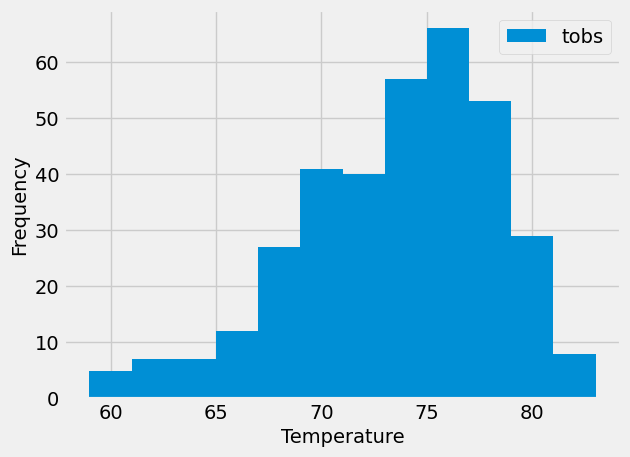

In [842]:
''' 4. Design a query to get the previous 12 months of temperature observation (TOBS) data. 
    To do so, complete the following steps:
    Filter by the station that has the greatest number of observations.

    Query the previous 12 months of TOBS data for that station.

    Plot the results as a histogram with bins=12, as the following image shows:
 '''
twelve_mo = session.query(measurement.tobs, measurement.date).filter(measurement.date >= prev_twelve_mo) \
                    .filter(measurement.station == most_active_station)
# twelve_mo.all()
twelve_mo_pd = pd.DataFrame(twelve_mo)
lab = ["tobs"]
histogram_plot = twelve_mo_pd['tobs']
histogram_plot.hist(bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(lab, loc = 'upper right')
plt.show()


# Close Session

In [843]:
# Close Session
session.close()